# CoT Based Smart Web Search

- Author: [syshin0116](https://github.com/syshin0116)
- Design: 
- Peer Review: 
- This is a part of [LangChain Open Tutorial](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/19-Cookbook/07-Agent/15-CoT-basedSmartWebSearch.ipynb) [![Open in GitHub](https://img.shields.io/badge/Open%20in%20GitHub-181717?style=flat-square&logo=github&logoColor=white)](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/19-Cookbook/07-Agent/15-CoT-basedSmartWebSearch.ipynb)

## Overview
This tutorial demonstrates a chain-of-thought (**CoT**) based smart web search approach designed to build a **plan-and-execute** style QA chatbot. The system breaks down complex user queries into a sequence of actionable steps such as **search**, **extraction**, **reasoning**, and **response generation**. It leverages large language models to perform each task, ensuring that every phase of the process is handled efficiently and accurately.

Throughout the tutorial, you will learn how to set up your environment, install the necessary packages, and define key data models using **`Pydantic`**. These models enforce a structured workflow by representing each task step (e.g., **search**, **think**, and **respond**) and by specifying how references and final outputs should be formatted in Markdown.

The workflow is composed of multiple nodes, each responsible for a specific phase of the processing pipeline. You will see how the system:

1. Generates a plan from a user query
2. Retrieves raw information from the web
3. Extracts and summarizes the relevant data
4. Optionally refines the results through additional reasoning
5. Compiles a comprehensive final answer

The nodes are dynamically connected through a routing function that adapts to the current state of the process.

A key aspect of this tutorial is the integration of **asynchronous execution**, which allows the entire workflow to run in real time. This not only improves performance but also provides immediate feedback during long-running tasks, making it easier to monitor and debug the process.

### Key Features

- **Chain-of-Thought Query Expansion**: Breaks down complex queries into manageable steps.  
- **Modular Workflow**: Separates the process into distinct nodes (planning, searching, extracting, reasoning, responding).  
- **Asynchronous Execution**: Enables real-time monitoring and concurrency for improved performance.  
- **Dynamic Task Routing**: Adapts the processing sequence based on the current state, ensuring each node is executed as needed.  
- **Robust Data Modeling**: Uses `Pydantic` to ensure consistent data structures and type safety.

### Table of Contents

- [Overview](#overview)
- [Environment Setup](#environment-setup)
- [Data Models and Type Definitions](#data-models-and-type-definitions)
- [Define Nodes for the Workflow](#define-nodes-for-the-workflow)
- [Route Tasks and Compile Workflow](#route-tasks-and-compile-workflow)
- [Run Workflow](#run-workflow)

### References

- [Language Agent Tree Search Unifies Reasoning Acting and Planning in Language Models](https://arxiv.org/abs/2310.04406)
- [Building (and Breaking) WebLangChain](https://blog.langchain.dev/weblangchain/)
- [Plan-and-Execute Agents](https://blog.langchain.dev/planning-agents/)
- [CopilotKit](https://github.com/CopilotKit/CopilotKit)
----

## Environment Setup

Setting up your environment is the first step. See the [Environment Setup](https://wikidocs.net/257836) guide for more details.


**[Note]**

The langchain-opentutorial is a package of easy-to-use environment setup guidance, useful functions and utilities for tutorials.
Check out the  [`langchain-opentutorial`](https://github.com/LangChain-OpenTutorial/langchain-opentutorial-pypi) for more details.

In [1]:
%%capture --no-stderr
%pip install langchain-opentutorial

# Install required packages
from langchain_opentutorial import package

package.install(
    [
        "langsmith",
        "langchain",
        "langchain_core",
        "langchain-anthropic",
        "langchain_community",
        "langchain_text_splitters",
        "langchain_openai",
    ],
    verbose=False,
    upgrade=False,
)

In [2]:
# Install required packages
from langchain_opentutorial import package

package.install(
    [],
    verbose=False,
    upgrade=False,
)

No packages to install.


In [3]:
# Set environment variables
from langchain_opentutorial import set_env

set_env(
    {
        "OPENAI_API_KEY": "",
        "LANGCHAIN_API_KEY": "",
        "LANGCHAIN_TRACING_V2": "true",
        "LANGCHAIN_ENDPOINT": "https://api.smith.langchain.com",
        "LANGCHAIN_PROJECT": "COT-based-smart-websearch",
        "TAVILY_API_KEY": "",
    }
)

Environment variables have been set successfully.


You can alternatively set API keys such as `OPENAI_API_KEY` in a `.env` file and load them.

[Note] This is not necessary if you've already set the required API keys in previous steps.

In [4]:
# Load API keys from .env file
from dotenv import load_dotenv

load_dotenv(override=True)

True

In [5]:
# import for asynchronous tasks
import asyncio
import nest_asyncio

nest_asyncio.apply()

## Data Models and Type Definitions

This section establishes the foundations for the entire tutorial by defining the key data structures using `Pydantic`. Our workflow relies on these models to ensure consistent information flow:

- `TaskStep` tracks a single step (either *search*, *think*, or *respond*).  
- `TaskSteps` holds a list of such steps.  
- `SearchQuries`, `KeyInformation`, and `SearchResultData` model how we handle web search queries and their results.  
- `Reference`and `FinalResponse` describe how we finalize and format the output response, including references.

Using these data models enforces structure, making the entire process easier to debug and maintain.

In [6]:
from pydantic import BaseModel, Field
from typing import Literal
from langchain.tools import tool
from typing import List, Optional, Annotated
from langgraph.graph import MessagesState
import operator
from typing_extensions import TypedDict
from pprint import pprint
from IPython.display import Markdown, display


class TaskStep(BaseModel):
    """
    Model for a task step in the research process
    Types:
      - "search": Retrieve raw information from the web
      - "think": (Optional) Further analyze or refine extracted data from search
      - "respond": Generate the final answer
    """

    id: str = Field(description="Unique identifier for the step")
    description: str = Field(
        description='Step description, e.g., "Search for latest AI news"'
    )
    status: Literal["pending", "completed"] = Field(
        description='Step status: "pending" or "completed"'
    )
    type: Literal["search", "think", "respond"] = Field(
        description='Step type: "search", "think", or "respond"'
    )


class TaskSteps(BaseModel):
    """
    Schema for a list of task steps
    """

    steps: List[TaskStep] = Field(description="List of task steps")


class SearchQuries(BaseModel):
    """
    Schema for search queries
    """

    search_queries: list = Field(
        description="List of Queries that are optimized for web search. Must contain at least 1 and at most 3 queries."
    )


class KeyInformation(BaseModel):
    """
    Schema for extracted key information from a search result.
    """

    title: str = Field(..., description="The title of the search result")
    key_information: Optional[str] = Field(
        None, description="Extracted key information with inline citations"
    )
    source_url: str = Field(..., description="The source URL of the search result")


class SearchResultData(BaseModel):
    """
    Schema for storing structured search results from Web Search.
    """

    query: str = Field(..., description="The search query that produced this result")
    results: List[KeyInformation] = Field(
        ..., description="Extracted information from search results"
    )


class Reference(BaseModel):
    """
    Schema for a reference
    """

    citation_id: int = Field(description="The citation id starting from 1")
    title: str = Field(description="The title of the reference")
    url: str = Field(description="The url of the reference")


class FinalResponse(BaseModel):
    """
    Schema for the final response
    """

    markdown: str = Field(
        description="The markdown formatted final response with inline citations. If you add any headings, make sure to start at level (##)"
    )
    references: list[Reference] = Field(description="A list of references")

### Define Agent and Worker State

In this part, two distinct state models are defined: one for the overall agent and one for individual worker tasks.

We use two different states:

1. `AgentState`: Represents the overall flow of the conversation, including steps, search results, think results, and the final answer.  
2. `WorkerState`: Manages the current task at a more granular level (e.g., one node’s execution).

This separation improves modularity and makes it simpler to track local vs. global information during a workflow run.

In [7]:
class AgentState(MessagesState):
    """
    The state of the agent.
    Contains the steps, search result, think result, and answer.
    """

    steps: Annotated[list, operator.add]
    search_result: Annotated[list, operator.add]
    think_result: Annotated[list, operator.add]
    answer: Optional[str]


class WorkerState(TypedDict):
    """
    The state of the worker.
    Contains the steps and the current step.
    """

    steps: Annotated[list, operator.add]
    current_step: TaskStep
    final_search_result: list

### Initialize Chat Models and Search Tool
We initialize two `ChatOpenAI` models:

- smart model: A more capable model (e.g., `gpt-4o`) used for planning or complex reasoning.  
- fast model: A lighter model (e.g., `gpt-4o-mini`) used for simpler tasks or when we prioritize speed.

This allows you to balance quality versus cost and speed. For instance, plan generation might use **smart model**, while quick lookups or shorter tasks might use **fast model**.

In [8]:
from langchain_openai import ChatOpenAI

smart_model = ChatOpenAI(model="gpt-4o", temperature=0.5)
fast_model = ChatOpenAI(model="gpt-4o-mini", temperature=0.5)

In [9]:
from langchain_community.tools import TavilySearchResults

# Initialize Tavily search tool
tavily = TavilySearchResults(
    max_results=3,
    search_depth="advanced",
    include_answer=True,
    include_raw_content=True,
    include_images=False,
)

## Define Nodes for the Workflow

A node in this workflow is a single unit of functionality—such as “plan steps”, “search the web”, “think about results”, or “respond to user”. Splitting the entire chain-of-thought (CoT) approach into nodes makes the system easier to extend and debug.

### Plan Steps Node
The **plan steps node** is the entry point of the workflow. It takes the user's query and generates a structured plan outlining the necessary steps to answer it. These steps include creating search tasks, optional think tasks for deeper analysis, and a final respond task to craft the answer. A well-defined plan here is crucial for effective execution in later nodes.

In [10]:
from datetime import datetime
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.runnables import RunnableConfig


async def plan_steps_node(state: AgentState, config: RunnableConfig):
    """
    Generate a plan of steps for the research process.
    The plan should include steps of type "search", and "respond".
    Optionally, a "think" step may be included if further analysis is desired.
    """
    instructions = f"""
You are an assistant specialized in breaking down complex queries into actionable steps.

Generate a plan of steps to find the answer to the user's query.
If the query is simple, you may directly create one "respond" step.

Divide the query into the following steps:
- First, create one or more "search" steps to retrieve raw information from the web.
- Optionally, create a "think" step to analyze the extracted data further.
- Finally, create a "respond" step to generate the final answer in markdown format.

Current date: {datetime.now().strftime("%Y-%m-%d")}.
"""
    response = await smart_model.with_structured_output(TaskSteps).ainvoke(
        [
            SystemMessage(content=instructions),
            HumanMessage(
                content=state["messages"][0].content,
            ),
        ],
        config,
    )
    print(f"🤖 Plan:")
    pprint(response.steps)
    return {"steps": response.steps}

### Search Node

This node handles external web search. It receives the step’s description, produces multiple queries, and calls the `TavilySearchResults` tool to get results. Each result is then summarized or filtered, before being passed on to the rest of the pipeline.

1. Generate multiple queries (to cover different angles).  
2. Perform the searches asynchronously.  
3. Store aggregated information for the next step.


In [11]:
import json
from datetime import datetime
from langchain_core.messages import SystemMessage, HumanMessage
from typing import List


async def search_node(state: WorkerState, config) -> dict:
    """
    Search node for the research process.

    1. Generate multiple search queries for the current step.
    2. For each query, asynchronously invoke the Tavily search tool and extract key information.
    3. Store the aggregated search results into current_step.data.
    """
    current_step = state.get("current_step")

    # Step 1: Generate multiple search queries
    system_instructions = f"""
You are an AI assistant specialized in generating search queries.
Based on the following step description, generate multiple relevant search queries.
Current date: {datetime.now().strftime("%Y-%m-%d")}.
"""
    human_instructions = f"Current step: {current_step.description}"

    response = await fast_model.with_structured_output(SearchQuries).ainvoke(
        [
            SystemMessage(content=system_instructions),
            HumanMessage(content=human_instructions),
        ],
        config,
    )
    search_queries: List[str] = response.search_queries

    # Step 2: Perform Tavily search and extract key information
    async def search_and_extract(query: str):
        print(f"🔎 Searching Query: {query}")
        result = await tavily.ainvoke(query)
        system_instructions_extract = """
You are an AI trained to extract key information from web search results.
Your task is to summarize the most relevant facts concisely.
Do NOT provide opinions or unnecessary details.
Format the result with inline citations like this: "Key fact[1]."
If the content is irrelevant, return only "irrelevant".
"""
        human_instructions_extract = f"""
Search Query: {query}

The following search result is provided:
{json.dumps(result, indent=2, ensure_ascii=False)}

Extract key information in the format:
- Title: <title>
- Key Information: <concise summary with inline citations>
- Source URL: <url>

If the result is irrelevant, return "irrelevant".
"""

        extract_result = await fast_model.with_structured_output(
            SearchResultData
        ).ainvoke(
            [
                SystemMessage(content=system_instructions_extract),
                HumanMessage(content=human_instructions_extract),
            ],
            config,
        )

        return extract_result

    # Step 3: Execute search queries concurrently
    search_tasks = [search_and_extract(query) for query in search_queries]
    aggregated_search_results: List[SearchResultData] = await asyncio.gather(
        *search_tasks
    )

    # Store the extracted search results
    search_result = [
        {
            "step_id": current_step.id,
            "search_result": [
                result.model_dump() for result in aggregated_search_results
            ],
        }
    ]

    return {"search_result": search_result}

### Collect Search Results Node

This optional node simply waits for all concurrent searches to finish and then aggregates the results. It does nothing beyond returning the existing state, but it ensures we have a single synchronization point before moving forward (useful in parallel “map” scenarios).

In [12]:
async def collect_search_results_node(
    state: AgentState, config: RunnableConfig
) -> dict:
    """
    Collection node for the search process.

    This node simply waits for all search results to be aggregated and then returns the state unchanged.
    It does not perform any additional processing.
    """
    return state

### Think Node

We optionally refine and analyze the data gathered from the search. If the user’s query is more complex, we insert a *think step* that leverages **fast_model** (or **smart_model**) to process the intermediate data. This can produce more concise or better-structured information to pass on to the final respond phase.


In [13]:
async def think_node(state: WorkerState, config: RunnableConfig):
    """
    Process extracted information for further analysis.
    This node is executed if there is a pending "think" step.
    """
    current_step = state.get("current_step")

    # System and Human Instructions
    system_instructions = """
You are an advanced reasoning AI designed to analyze and refine information.
Carefully evaluate the provided data to enhance its clarity and completeness.
Focus on refining the information relevant to the given objective.
"""

    human_instructions = f"""
Objective: {current_step.description}

Based on the extracted data:

Search Results:
{state['final_search_result']}

Please analyze and refine this information to make it more useful for answering the final query.
"""

    response = await fast_model.ainvoke(
        [
            SystemMessage(content=system_instructions),
            HumanMessage(content=human_instructions),
        ],
        config,
    )
    print(f"🧠 Think Result:")

    # Display the think result
    result_for_dislay = (
        response.content[:1000] + "\n\n...output cut to prevent excessive output..."
        if len(response.content) > 1000
        else response.content
    )
    display(Markdown(result_for_dislay))
    # Store thought result
    think_result = [{"step_id": current_step.id, "think_result": response.content}]

    return {"think_result": think_result}

### Response Node

Finally, we combine all steps, including the user’s query, search results, and optional *think* results, into a coherent answer. The answer is generated in Markdown, with inline citations and references appended at the end.

This step demonstrates how we can produce a well-formatted, easily readable response to the end user.

In [14]:
async def response_node(state: AgentState, config: RunnableConfig):
    """
    This node compiles all intermediate data (steps, search results, think results)
    into a final answer. The answer is formatted in Markdown, including inline
    citations pointing to references at the bottom.

    1. system_instructions: Provides a template for how the final answer
       should look, with examples of inline citations.
    2. human_instructions: Provides user context (query) and any relevant
       steps or data collected throughout the workflow.

    The node uses the 'smart_model' (gpt-4o) with structured output to produce
    a FinalResponse object, which contains both Markdown text and a list of
    references.
    """

    # System instructions for formatting the final answer
    system_instructions = """
You are an AI assistant tasked with producing a comprehensive final answer in Markdown format.
Your goal is to clearly address the user's original query by synthesizing all relevant steps.

Instructions:
1. Use inline citations, referencing a separate list of references at the bottom of the output.
2. If you need to include headings, start at (##) to avoid overshadowing existing documentation levels.
3. Write succinctly and accurately, ensuring any claims are supported by the references.
4. Example inline citation usage:
    This is a sentence with a reference to a source[1] and another reference[2].
    [1]: [Title of Source 1](http://example.com/source1)
    [2]: [Title of Source 2](http://example.com/source2)
"""

    # Human instructions that provide specific context (query, steps, results, etc.)
    human_instructions = f"""
User Query: {state["messages"][0].content}

Steps completed to answer user query:
{state["steps"]}

Search Results:
{state["search_result"]}

Think Results:
{state["think_result"]}
    """

    # Invoke the smart model to produce structured output (FinalResponse)
    response = await smart_model.with_structured_output(FinalResponse).ainvoke(
        [
            SystemMessage(content=system_instructions),
            HumanMessage(content=human_instructions),
        ],
        config,
    )

    # Print the final Markdown answer
    print(f"📝 Final Response:")
    display(Markdown(response.markdown))
    print()
    print("References:\n")
    for ref in response.references:
        print(f"[{ref.citation_id}] {ref.title}\n    {ref.url}\n")

    # Return the structured FinalResponse object as "answer"
    return {"answer": response}

## Route Tasks and Compile Workflow

This portion of the tutorial shows how to:

1. Decide which step should execute next (the task router).  
2. Build our entire workflow as a graph, using the `StateGraph` class.  
3. Visualize the graph to confirm all nodes connect properly.  

Combining these elements provides a clear flow from plan → search → optional think → respond, with conditionals for concurrency.

### Task Router Function

The router examines all pending steps. If we find one or more search steps (marked pending), we dispatch them concurrently using the `Send` object. If no search steps remain, we look for think or respond steps. When none remain, we conclude by returning `END`.

This ensures the system adapts dynamically: if a step is done, it moves on to the next relevant step without manual intervention.


In [15]:
from langgraph.constants import Send
from langgraph.graph import END


def task_router(state):
    """
    Route to the appropriate node based on the pending step type.
    - If a pending "search" step exists, dispatch it (via Send) so that search_node
      executes and then flows automatically into extraction_node.
    - Else if a pending "think" step exists, route to think_node.
    - Else if a pending "respond" step exists, route to response_node.
    - If no pending steps remain, return END.
    """
    steps_list = state.get("steps", [])

    pending_search = [
        step
        for step in steps_list
        if step.status == "pending" and step.type == "search"
    ]
    if pending_search:
        for step in pending_search:
            step.status = "complete"  # Update status before dispatching
        return [
            Send("search_node", {"steps": steps_list, "current_step": step})
            for step in pending_search
        ]
    else:
        for step in steps_list:
            if step.status == "pending":
                if step.type == "think":
                    step.status = "complete"
                    return Send(
                        "think_node",
                        {
                            "steps": steps_list,
                            "current_step": step,
                            "final_search_result": state.get("search_result", []),
                        },
                    )
                elif step.type == "respond":
                    return "response_node"
    return END

### Build Workflow Graph

We add nodes to the workflow using `.add_node(...)`, specify the start node (plan_steps_node), and link them with `.add_edge(...)` or `.add_conditional_edges(...)`. Then we compile with a `MemorySaver` checkpoint mechanism (optional) to track states.

Graph-based logic clarifies how each node transitions to the next, whether conditionally or directly.


In [16]:
from langgraph.graph import StateGraph
from langgraph.checkpoint.memory import MemorySaver

workflow = StateGraph(AgentState)

# Define nodes
workflow.add_node("plan_steps_node", plan_steps_node)
workflow.add_node("search_node", search_node)
workflow.add_node("collect_search_results_node", collect_search_results_node)
workflow.add_node("think_node", think_node)
workflow.add_node("response_node", response_node)

# Set entry point
workflow.set_entry_point("plan_steps_node")

# After planning, route according to pending step types.
workflow.add_conditional_edges(
    "plan_steps_node", task_router, ["search_node", "think_node", "response_node"]
)

# Search node flows into collect_search_results_node
workflow.add_edge("search_node", "collect_search_results_node")

# Ensure search_node automatically flows back into task_router
workflow.add_conditional_edges(
    "collect_search_results_node", task_router, ["think_node", "response_node"]
)

# If a think step exists, it flows to the response node.
workflow.add_edge("think_node", "response_node")

# Response node marks the end.
workflow.add_edge("response_node", END)

# Compile the workflow
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)

### Visualize Graph

For debugging or documentation, we can generate a diagram of our graph’s nodes and edges. This makes it easy to see the plan from start to finish, identify concurrency, and check for mistakes (like a node missing an edge to the final stage).

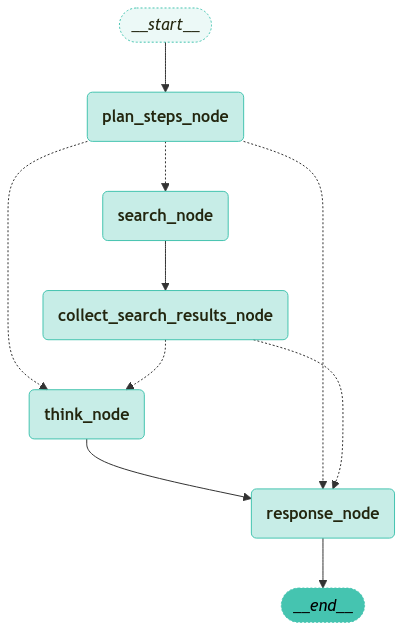

In [17]:
from langchain_opentutorial.graphs import visualize_graph

visualize_graph(graph)

## Run Workflow

Here, we demonstrate the end-to-end execution:

1. **Configure** the run parameters (e.g., thread IDs or optional debugging).  
2. **Initialize** the graph with the user’s query.  
3. **Execute** asynchronously, streaming real-time results.  

Finally, we show how to examine the final state—looking at the produced Markdown answer and references.


### Streaming Graph Execution

We define `astream_graph(...)` to retrieve and print updates during the run. Each node’s outputs appear in real time, letting you monitor progress and debug problems such as missing data or infinite loops.

In [18]:
from typing import Any, Dict, List, Callable
from langchain_core.runnables import RunnableConfig
from langgraph.graph.state import CompiledStateGraph


async def astream_graph(
    graph: CompiledStateGraph,
    inputs: Dict[str, Any],
    config: RunnableConfig,
    node_names: List[str] = [],
    callback: Callable[[Dict[str, str]], None] = None,
):
    """
    Asynchronously streams the execution results of a LangGraph.

    Parameters:
    - graph (CompiledStateGraph): The compiled LangGraph to be executed.
    - inputs (dict): The input data dictionary to be passed to the graph.
    - config (RunnableConfig): Execution configuration.
    - node_names (List[str], optional): List of node names to filter output (empty list means all nodes).
    - callback (Callable[[Dict[str, str]], None], optional): A callback function for processing each chunk.
      The callback receives a dictionary with keys "node" (str) and "content" (str).

    Returns:
    - None: This function prints the streaming output but does not return any value.
    """
    prev_node = ""
    async for chunk_msg, metadata in graph.astream(
        inputs, config, stream_mode="messages"
    ):
        curr_node = metadata["langgraph_node"]

        # Process only the specified nodes if node_names is not empty
        if not node_names or curr_node in node_names:
            if callback:
                callback({"node": curr_node, "content": chunk_msg.content})
            else:
                # Print a header whenever the node changes
                if curr_node != prev_node:
                    print("\n" + "=" * 60)
                    print(f"🔄 Node: \033[1;36m{curr_node}\033[0m 🔄")
                    print("=" * 60)

            prev_node = curr_node

### Configure and Run Workflow Graph

We create a `config`, store it in `memory` if needed, and supply the user’s query. The asynchronous execution triggers each node in the correct order.

In [19]:
# Configuration
config = {
    "configurable": {
        "thread_id": 1,  # temporary thread ID for testing
    },
}

inputs = AgentState(
    messages=[
        HumanMessage(
            content="How did the implementation of artificial intelligence in supply chain management during the COVID-19 pandemic impact global trade efficiency, and what are the current trends and future projections for AI-driven supply chains in the next decade?"
        )
    ],
    steps=[],
    answer=None,
)

In [20]:
# Execute the graph asynchronously
await astream_graph(graph, inputs, config=config)


🔄 Node: plan_steps_node 🔄
🤖 Plan:
[TaskStep(id='step1', description='Search for articles and studies on the impact of AI in supply chain management during the COVID-19 pandemic and its effects on global trade efficiency.', status='pending', type='search'),
 TaskStep(id='step2', description='Search for current trends in AI-driven supply chains.', status='pending', type='search'),
 TaskStep(id='step3', description='Search for future projections of AI in supply chain management over the next decade.', status='pending', type='search'),
 TaskStep(id='step4', description='Analyze the collected information to determine the impact of AI on global trade efficiency during the pandemic and summarize current and future trends.', status='pending', type='think'),
 TaskStep(id='step5', description='Respond with a summary of the impact of AI on supply chain management during the COVID-19 pandemic, current trends, and future projections.', status='pending', type='respond')]

🔄 Node: search_node 🔄
🔎 Se

### Impact of AI on Global Trade Efficiency During the Pandemic

#### Overview
The COVID-19 pandemic significantly disrupted global trade and supply chains, highlighting vulnerabilities across industries. Artificial Intelligence (AI) emerged as a critical tool for enhancing supply chain efficiency and resilience during this period. 

#### Key Findings on AI's Impact During the Pandemic

1. **Enhancing Resilience**: 
   - AI improved supply chain resilience by providing enhanced transparency and real-time insights. This allowed companies to adapt quickly to disruptions, ensuring last-mile delivery and minimizing the impact of supply chain interruptions. AI facilitated agile procurement strategies, which were essential during the pandemic ([source](https://rgu-repository.worktribe.com/OutputFile/2166136)).
   - Research indicated that AI could enhance supply chain management efficiency by up to 40% through effective data processing and trend prediction ([source](https://hypersonix.ai/blo

...output cut to prevent excessive output...


🔄 Node: response_node 🔄
📝 Final Response:


## Impact of AI on Global Trade Efficiency During the Pandemic

### Overview
The COVID-19 pandemic significantly disrupted global trade and supply chains, revealing vulnerabilities across industries. Artificial Intelligence (AI) emerged as a crucial tool for enhancing supply chain efficiency and resilience during this period.

### Key Findings on AI's Impact During the Pandemic

1. **Enhancing Resilience**: AI improved supply chain resilience by providing enhanced transparency and real-time insights, allowing companies to adapt quickly to disruptions, ensuring last-mile delivery, and minimizing the impact of supply chain interruptions. AI facilitated agile procurement strategies essential during the pandemic[1][2].

2. **Data-Driven Decision Making**: Companies shifted from cost-driven approaches to data-driven strategies, utilizing AI to analyze diverse data sources for predicting disruptions and developing resilience, thereby gaining a competitive advantage post-pandemic[3]. AI's role in synchronizing manufacturing and inventory planning was crucial for mitigating pandemic disruptions[4].

3. **Transformative Automation**: The integration of AI and automation transformed logistics and supply chain operations, enabling fully automated, transparent supply chains vital for future global trade[5].

## Current Trends in AI-Driven Supply Chains (2025)

1. **AI Revolutionizing Operations**: By 2025, AI is expected to continue revolutionizing supply chains, focusing on enhancing efficiency and resilience. Key trends include the utilization of generative AI for improved decision-making and demand prediction[6]. Supply chain leaders must navigate geopolitical uncertainties and technological changes while embracing predictive technologies[7].

2. **Focus on Sustainability**: AI is poised to drive sustainability in supply chains through optimized route planning and predictive capabilities, leading to cost reductions and improved operational efficiency[8].

3. **Dynamic Inventory Management**: AI will play a crucial role in addressing challenges such as geopolitical conflicts and resource scarcity by enabling dynamic inventory management and maximizing productivity[9].

## Future Projections for AI in Supply Chain Management (2035)

1. **Hyperconnected Supply Chains**: By 2035, supply chains are expected to be directed by artificial superintelligence, utilizing deep learning and swarm coordination algorithms. This will lead to decentralized networks supported by blockchain protocols, enhancing tracking and coordination[10].

2. **Transforming Business Models**: Companies will convert their supply chains into value networks to drive growth, leveraging AI and machine learning as key enablers for competitive advantage[11].

3. **Mitigating Risks and Enhancing Resilience**: Advanced technologies, including AI, will be essential in enhancing supply chain visibility and resilience, enabling organizations to respond quickly to disruptions and minimize inefficiencies[12].

## Conclusion
The pandemic underscored the importance of AI in enhancing global trade efficiency, with trends indicating a continued reliance on AI technologies to bolster supply chain resilience, operational efficiency, and sustainability. As we look toward 2025 and beyond, businesses must adapt to these trends to remain competitive in an increasingly complex global trade environment.


References:

[1] AI for Enhanced Supply Chain Resilience
    https://rgu-repository.worktribe.com/OutputFile/2166136

[2] Artificial Intelligence for Supply Chain Resilience: Learning from Covid-19
    https://www.emerald.com/insight/content/doi/10.1108/IJLM-02-2021-0094/full/html

[3] Managing Postpandemic Supply-Chains With Artificial Intelligence
    https://www.bioprocessintl.com/sponsored-content/the-role-of-artificial-intelligence-in-managing-postpandemic-supply-chain-risks

[4] AI technologies and their impact on supply chain resilience during COVID-19
    https://www.emerald.com/insight/content/doi/10.1108/ijpdlm-12-2020-0434/full/html

[5] The Impact of Automation and AI on Supply Chain Efficiency: Transforming Logistics for the Future
    https://www.globaltrademag.com/the-impact-of-automation-and-ai-on-supply-chain-efficiency-transforming-logistics-for-the-future/

[6] Supply Chain Trends for 2025
    https://www.forbes.com/sites/ashokviswanathan/2025/01/04/supply-chain-tre

### Examine Final State and Display Answer

Once the pipeline completes, we retrieve the final state from the compiled graph. This includes the final Markdown-based answer with inline references and any metadata we collected along the way. The final result is displayed for clarity, concluding the entire process.

In [21]:
# Examine the final markdown answer
Markdown(graph.get_state(config).values["answer"].markdown)

## Impact of AI on Global Trade Efficiency During the Pandemic

### Overview
The COVID-19 pandemic significantly disrupted global trade and supply chains, revealing vulnerabilities across industries. Artificial Intelligence (AI) emerged as a crucial tool for enhancing supply chain efficiency and resilience during this period.

### Key Findings on AI's Impact During the Pandemic

1. **Enhancing Resilience**: AI improved supply chain resilience by providing enhanced transparency and real-time insights, allowing companies to adapt quickly to disruptions, ensuring last-mile delivery, and minimizing the impact of supply chain interruptions. AI facilitated agile procurement strategies essential during the pandemic[1][2].

2. **Data-Driven Decision Making**: Companies shifted from cost-driven approaches to data-driven strategies, utilizing AI to analyze diverse data sources for predicting disruptions and developing resilience, thereby gaining a competitive advantage post-pandemic[3]. AI's role in synchronizing manufacturing and inventory planning was crucial for mitigating pandemic disruptions[4].

3. **Transformative Automation**: The integration of AI and automation transformed logistics and supply chain operations, enabling fully automated, transparent supply chains vital for future global trade[5].

## Current Trends in AI-Driven Supply Chains (2025)

1. **AI Revolutionizing Operations**: By 2025, AI is expected to continue revolutionizing supply chains, focusing on enhancing efficiency and resilience. Key trends include the utilization of generative AI for improved decision-making and demand prediction[6]. Supply chain leaders must navigate geopolitical uncertainties and technological changes while embracing predictive technologies[7].

2. **Focus on Sustainability**: AI is poised to drive sustainability in supply chains through optimized route planning and predictive capabilities, leading to cost reductions and improved operational efficiency[8].

3. **Dynamic Inventory Management**: AI will play a crucial role in addressing challenges such as geopolitical conflicts and resource scarcity by enabling dynamic inventory management and maximizing productivity[9].

## Future Projections for AI in Supply Chain Management (2035)

1. **Hyperconnected Supply Chains**: By 2035, supply chains are expected to be directed by artificial superintelligence, utilizing deep learning and swarm coordination algorithms. This will lead to decentralized networks supported by blockchain protocols, enhancing tracking and coordination[10].

2. **Transforming Business Models**: Companies will convert their supply chains into value networks to drive growth, leveraging AI and machine learning as key enablers for competitive advantage[11].

3. **Mitigating Risks and Enhancing Resilience**: Advanced technologies, including AI, will be essential in enhancing supply chain visibility and resilience, enabling organizations to respond quickly to disruptions and minimize inefficiencies[12].

## Conclusion
The pandemic underscored the importance of AI in enhancing global trade efficiency, with trends indicating a continued reliance on AI technologies to bolster supply chain resilience, operational efficiency, and sustainability. As we look toward 2025 and beyond, businesses must adapt to these trends to remain competitive in an increasingly complex global trade environment.

In [22]:
# Examine references
for ref in graph.get_state(config).values["answer"].references:
    print(f"[{ref.citation_id}] {ref.title}\n    {ref.url}\n")

[1] AI for Enhanced Supply Chain Resilience
    https://rgu-repository.worktribe.com/OutputFile/2166136

[2] Artificial Intelligence for Supply Chain Resilience: Learning from Covid-19
    https://www.emerald.com/insight/content/doi/10.1108/IJLM-02-2021-0094/full/html

[3] Managing Postpandemic Supply-Chains With Artificial Intelligence
    https://www.bioprocessintl.com/sponsored-content/the-role-of-artificial-intelligence-in-managing-postpandemic-supply-chain-risks

[4] AI technologies and their impact on supply chain resilience during COVID-19
    https://www.emerald.com/insight/content/doi/10.1108/ijpdlm-12-2020-0434/full/html

[5] The Impact of Automation and AI on Supply Chain Efficiency: Transforming Logistics for the Future
    https://www.globaltrademag.com/the-impact-of-automation-and-ai-on-supply-chain-efficiency-transforming-logistics-for-the-future/

[6] Supply Chain Trends for 2025
    https://www.forbes.com/sites/ashokviswanathan/2025/01/04/supply-chain-trends-for-2025/
